In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
def get_skus(n):
    r_skus = np.arange(1, n+1,1)
    sku_perc = np.random.dirichlet(np.ones(len(r_skus))*1000.,size=1)
    return pd.DataFrame(list(zip(r_skus, sku_perc[0])), columns=['sku', 'sku_percent'])

In [13]:
# Let's make a few SKUs...somewhere above 20 sku, the sampling below will fail
df_skus = get_skus(5)
df_skus

,sku,sku_percent
0,1,0.202647
1,2,0.204323
2,3,0.189856
3,4,0.197730
4,5,0.205443


In [14]:
n_samples, n_burn = 1000, 3000

# historically, we observe that this style is bought 35% of the time, but this could obviously vary
style_percent_obs = 0.35

# we plan 10000 units of demand for next year
demand_planned = 10000

with pm.Model() as model:

    # we'll model the style distribution as a beta prior
    style_percent = pm.Beta('style_percent', mu=style_percent_obs, sd=style_percent_obs*.01, testval=style_percent_obs)
    style_demand = pm.Deterministic('style_demand', demand_planned * style_percent)
    
    # then for every sku, we model the sku distribution as a beta prior and
    # we want to determine the distribution of the resulting sku demand to be planned in units
    for _, sku in df_skus.iterrows():
        
        i = sku['sku']
        sku_percent_obs = sku['sku_percent']
        sku_demand_obs = np.ceil(demand_planned * style_percent_obs * sku_percent_obs)
        
        # the SKU % is also modeled as a Beta prior
        sku_perc = pm.Beta(f'sku_percent_{i}', mu=sku_percent_obs, sd=sku_percent_obs*.01, testval=sku_percent_obs)

        sku_demand = pm.Deterministic(f'sku_demand_{i}', style_demand * sku_perc)

        sku_planned = pm.Poisson(f'sku_planned_{i}', mu=sku_demand, observed=sku_demand_obs)

    trace = pm.sample(n_samples, tune=n_burn, random_seed=42, progressbar=True) 

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 288.46:   5%|▌         | 10503/200000 [00:01<00:29, 6531.38it/s]
Convergence archived at 10700
Interrupted at 10,700 [5%]: Average Loss = 2,643.5
INFO (theano.gof.compilelock): Refreshing lock /Users/claus/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir/lock
100%|██████████| 4000/4000 [00:08<00:00, 456.92it/s]


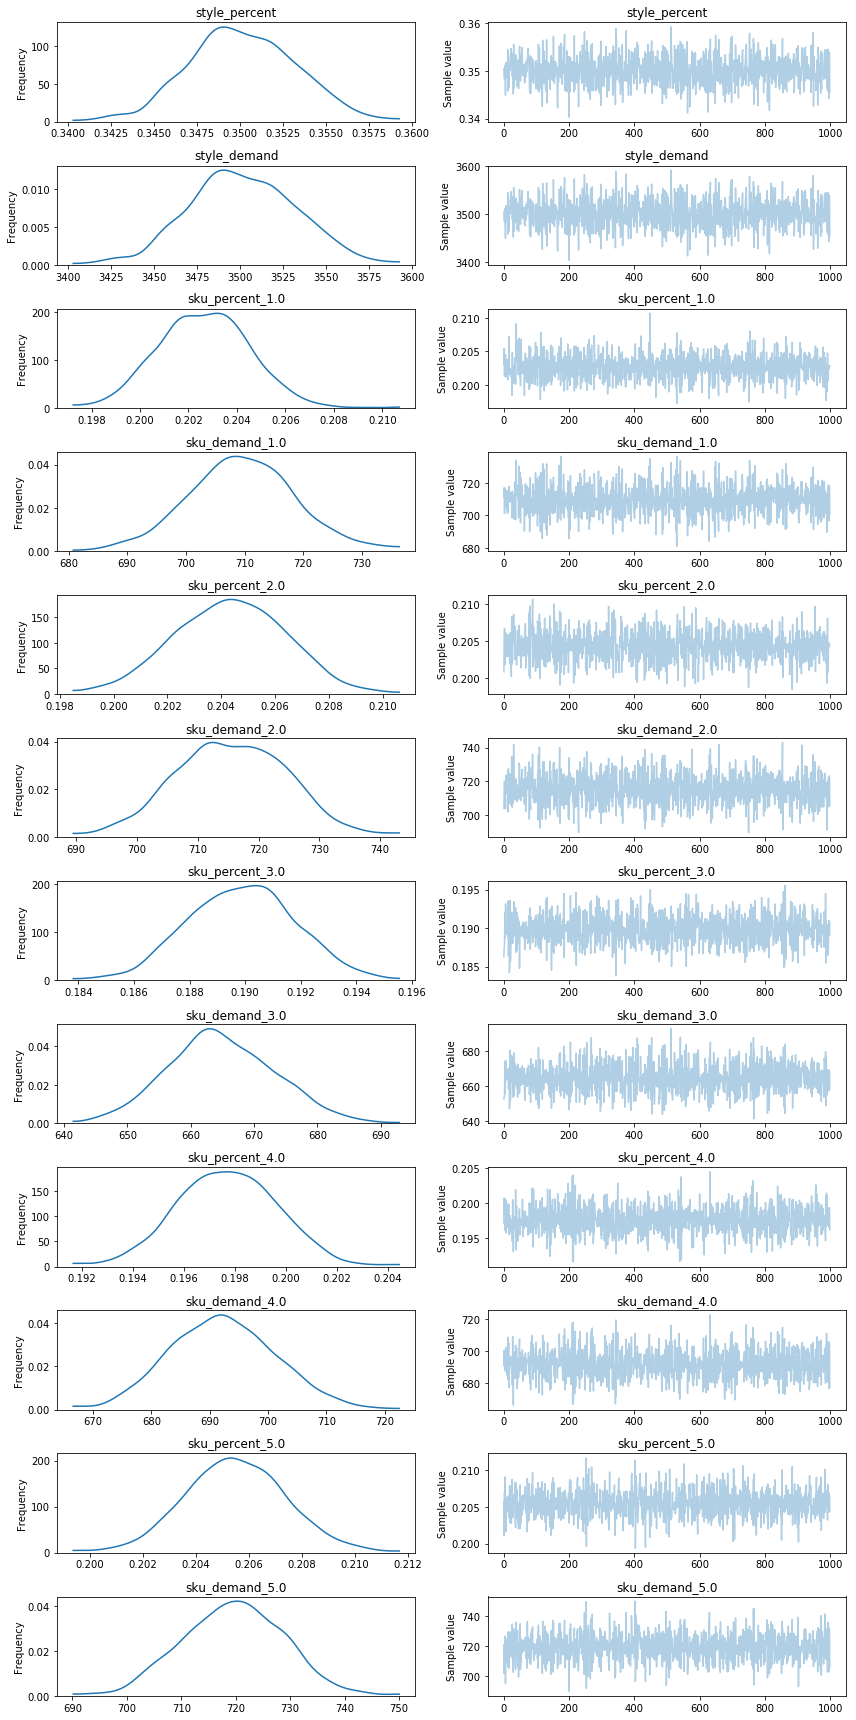

In [15]:
pm.traceplot(trace);